<a href="https://colab.research.google.com/github/gabriellaaileen/pillar-stability-prediction/blob/main/Pillar_Stability_Prediction_Ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Requirements**

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow import nn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import tensorflow as tf

In [3]:
!wget -P data/ https://raw.githubusercontent.com/gabriellaaileen/pillar-stability-prediction/main/"Data gabungan 2.csv"

--2022-08-20 09:46:22--  https://raw.githubusercontent.com/gabriellaaileen/pillar-stability-prediction/main/Data%20gabungan%202.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10806 (11K) [text/plain]
Saving to: ‘data/Data gabungan 2.csv’

Data gabungan 2.csv 100%[===================>]  10.55K  --.-KB/s    in 0s      

2022-08-20 09:46:22 (80.6 MB/s) - ‘data/Data gabungan 2.csv’ saved [10806/10806]



In [4]:
df = pd.read_csv('/content/data/Data gabungan 2.csv')

#**Exploratory Data Analysis**

In [5]:
df.head(5)

,Depth,PW,BW,MH,Stability
0,76.2,4.88,6.10,1.37,Failed
1,29.0,5.40,6.30,2.90,Failed
2,60.0,7.00,6.00,1.82,Failed
3,53.0,5.60,6.10,1.80,Failed
4,21.0,6.75,5.25,3.20,Failed


In [6]:
df.shape

(423, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Depth      423 non-null    float64
 1   PW         423 non-null    float64
 2   BW         423 non-null    float64
 3   MH         423 non-null    float64
 4   Stability  423 non-null    object 
dtypes: float64(4), object(1)
memory usage: 16.6+ KB


In [8]:
#Menghitung presentase missing values dari masing-masing variabel
(df.isnull().sum()/len(df)*100).to_frame('Persentase Missing Value Dataset (%)')

,Persentase Missing Value Dataset (%)
Depth,0.0
PW,0.0
BW,0.0
MH,0.0
Stability,0.0


In [9]:
df.describe()

,Depth,PW,BW,MH
count,423.000000,423.000000,423.000000,423.000000
mean,77.546194,9.948558,6.088818,3.000686
std,44.716598,4.919084,0.616702,1.122797
min,13.220000,2.740000,3.690000,1.000000
25%,45.335000,6.195000,5.975000,2.200000
50%,66.000000,9.000000,6.000000,2.920000
75%,96.000000,12.095000,6.375000,3.650000
max,254.450000,35.000000,10.000000,6.450000


In [10]:
print(df.groupby(['Stability']).agg({"Stability": "count"}), end="\n\n\n")

           Stability
Stability           
Failed            86
Intact           337




In [11]:
import plotly.io as pio
import plotly.express as px
import plotly.offline as py

fig = px.scatter(df, x="Depth", y="PW", color="Stability", size="BW")
fig

#**Preprocessing**

##Imbalance dataset

In [12]:
X, y = df.drop('Stability', axis=1),df['Stability']

###Oversampling

In [13]:
# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [14]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [15]:
X_resampled, y_resampled = ros.fit_resample(X, y)

### Undersampling

In [113]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

###Hasil

In [16]:
print(X_resampled)

     Depth     PW    BW    MH
0     76.2   4.88  6.10  1.37
1     29.0   5.40  6.30  2.90
2     60.0   7.00  6.00  1.82
3     53.0   5.60  6.10  1.80
4     21.0   6.75  5.25  3.20
..     ...    ...   ...   ...
669  112.0  10.55  6.45  2.82
670   61.0   6.10  6.10  4.57
671   62.0   7.50  6.40  4.00
672   53.3   5.18  6.40  3.66
673   41.0   6.40  6.40  6.20

[674 rows x 4 columns]


In [17]:
print(y_resampled)

0      Failed
1      Failed
2      Failed
3      Failed
4      Failed
        ...  
669    Failed
670    Failed
671    Failed
672    Failed
673    Failed
Name: Stability, Length: 674, dtype: object


In [18]:
df=pd.concat([X_resampled, y_resampled], axis=1)
df.head()

,Depth,PW,BW,MH,Stability
0,76.2,4.88,6.10,1.37,Failed
1,29.0,5.40,6.30,2.90,Failed
2,60.0,7.00,6.00,1.82,Failed
3,53.0,5.60,6.10,1.80,Failed
4,21.0,6.75,5.25,3.20,Failed


In [19]:
print(df.groupby(['Stability']).agg({"Stability": "count"}), end="\n\n\n")

           Stability
Stability           
Failed           337
Intact           337




##Label Encoding

In [20]:
#Split dataset menjadi feature (X) dan label (y)
y = df['Stability']
X = df.drop(columns=['Stability'])

In [21]:
le = LabelEncoder()
y = le.fit_transform(y)

In [22]:
dictionary={}
for i in range(len(list(le.classes_))):
  dictionary[list(le.classes_)[i]]=i
dictionary

{'Failed': 0, 'Intact': 1}

##Split Dataset (Train - Val - Test)

**Train - Test Split**

In [121]:
#Split train dan test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

**Train - Val - Test Split**

In [23]:
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [24]:
X_train.shape

(539, 4)

In [25]:
X_valid.shape

(67, 4)

In [26]:
X_test.shape

(68, 4)

In [27]:
X_train

,Depth,PW,BW,MH
8,42.00,4.50,5.50,2.00
641,86.40,7.50,6.50,4.60
551,104.00,12.00,6.00,3.00
43,104.00,12.00,6.00,3.00
244,61.50,9.26,6.00,1.98
...,...,...,...,...
105,19.40,4.26,5.22,1.40
99,26.83,2.91,5.09,1.33
22,165.70,15.00,5.00,5.94
664,51.50,6.00,6.00,3.90


In [28]:
y_train

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,

#**Build Model**

In [29]:
adam = Adam(learning_rate=0.001)

In [30]:
#Callback
callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    mode='auto'
)

##Model 1 (Activation function: Linear)

In [31]:
model_1 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.linear),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])

In [32]:
model_1.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [204]:
model_1.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 512)               2560      
                                                                 
 dense_98 (Dense)            (None, 256)               131328    
                                                                 
 dense_99 (Dense)            (None, 256)               65792     
                                                                 
 dense_100 (Dense)           (None, 128)               32896     
                                                                 
 dense_101 (Dense)           (None, 1)                 129       
                                                                 
Total params: 232,705
Trainable params: 232,705
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model_1.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=400, callbacks=callback,  verbose=1)

Epoch 1/400
34/34 [==============================] - 1s 12ms/step - loss: 2.9585 - accuracy: 0.5417 - val_loss: 1.0591 - val_accuracy: 0.5075
Epoch 2/400
34/34 [==============================] - 0s 5ms/step - loss: 0.6224 - accuracy: 0.6642 - val_loss: 0.6506 - val_accuracy: 0.6567
Epoch 3/400
34/34 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.6605 - val_loss: 0.7133 - val_accuracy: 0.6269
Epoch 4/400
34/34 [==============================] - 0s 5ms/step - loss: 0.6540 - accuracy: 0.6475 - val_loss: 0.5991 - val_accuracy: 0.6418
Epoch 5/400
34/34 [==============================] - 0s 5ms/step - loss: 0.6491 - accuracy: 0.6827 - val_loss: 0.6527 - val_accuracy: 0.6418
Epoch 6/400
34/34 [==============================] - 0s 7ms/step - loss: 0.5613 - accuracy: 0.7328 - val_loss: 0.5882 - val_accuracy: 0.6716
Epoch 7/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5725 - accuracy: 0.7254 - val_loss: 0.5640 - val_accuracy: 0.6866
Epoch 8/400


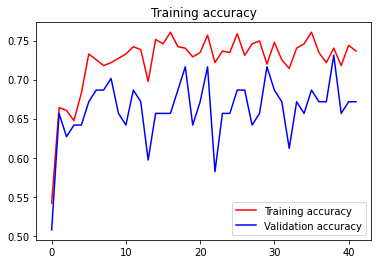

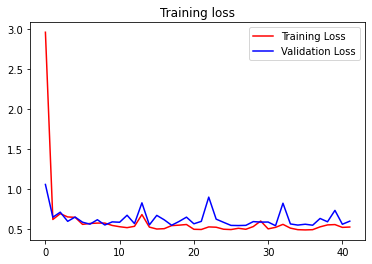

In [35]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [36]:
model_1.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.5204 - accuracy: 0.7206


[0.5204317569732666, 0.720588207244873]

##Model 2 (Activation function: ReLU)

In [37]:
model_2 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])

In [38]:
model_2.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [ ]:
model_2.summary()

In [39]:
history = model_2.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=400, callbacks=callback, verbose=1)

Epoch 1/400
34/34 [==============================] - 1s 11ms/step - loss: 1.3005 - accuracy: 0.5362 - val_loss: 0.6953 - val_accuracy: 0.4925
Epoch 2/400
34/34 [==============================] - 0s 5ms/step - loss: 0.6641 - accuracy: 0.6104 - val_loss: 0.8256 - val_accuracy: 0.5224
Epoch 3/400
34/34 [==============================] - 0s 6ms/step - loss: 0.6320 - accuracy: 0.6549 - val_loss: 0.7307 - val_accuracy: 0.5970
Epoch 4/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5411 - accuracy: 0.7236 - val_loss: 0.5859 - val_accuracy: 0.6418
Epoch 5/400
34/34 [==============================] - 0s 6ms/step - loss: 0.6015 - accuracy: 0.6735 - val_loss: 0.5575 - val_accuracy: 0.6866
Epoch 6/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5651 - accuracy: 0.6957 - val_loss: 0.6756 - val_accuracy: 0.5970
Epoch 7/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5637 - accuracy: 0.7180 - val_loss: 0.5932 - val_accuracy: 0.6269
Epoch 8/400


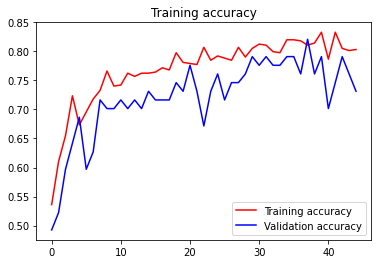

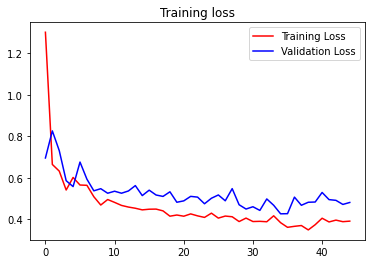

In [40]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [41]:
model_2.evaluate(X_test, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 0.3839 - accuracy: 0.8676


[0.3839488923549652, 0.8676470518112183]

##Model 3

In [42]:
model_3 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.elu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])

In [43]:
model_3.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [44]:
history = model_3.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=400, callbacks=callback,  verbose=1)

Epoch 1/400
34/34 [==============================] - 1s 11ms/step - loss: 1.4937 - accuracy: 0.5677 - val_loss: 0.7934 - val_accuracy: 0.5224
Epoch 2/400
34/34 [==============================] - 0s 6ms/step - loss: 0.7629 - accuracy: 0.5751 - val_loss: 0.6450 - val_accuracy: 0.5373
Epoch 3/400
34/34 [==============================] - 0s 6ms/step - loss: 0.6664 - accuracy: 0.6531 - val_loss: 0.6374 - val_accuracy: 0.5672
Epoch 4/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5732 - accuracy: 0.6939 - val_loss: 0.5789 - val_accuracy: 0.7015
Epoch 5/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5500 - accuracy: 0.7180 - val_loss: 0.7816 - val_accuracy: 0.5672
Epoch 6/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5576 - accuracy: 0.7291 - val_loss: 0.5428 - val_accuracy: 0.6866
Epoch 7/400
34/34 [==============================] - 0s 6ms/step - loss: 0.4905 - accuracy: 0.7532 - val_loss: 0.6325 - val_accuracy: 0.6418
Epoch 8/400


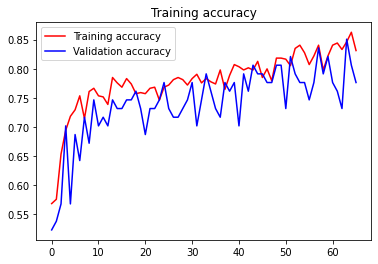

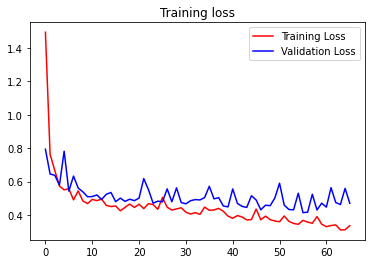

In [45]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [46]:
model_3.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.4063 - accuracy: 0.8824


[0.4063361585140228, 0.8823529481887817]

##Model 4

In [47]:
model_4 = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512, input_shape=[4],activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(256, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                    ])

In [48]:
model_4.compile(loss="binary_crossentropy",optimizer=adam,metrics=['accuracy'])

In [49]:
history = model_4.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size=16, epochs=400, callbacks=callback,  verbose=1)

Epoch 1/400
34/34 [==============================] - 2s 12ms/step - loss: 1.1711 - accuracy: 0.4861 - val_loss: 0.6659 - val_accuracy: 0.5224
Epoch 2/400
34/34 [==============================] - 0s 6ms/step - loss: 0.6231 - accuracy: 0.6512 - val_loss: 0.6424 - val_accuracy: 0.6418
Epoch 3/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5443 - accuracy: 0.7161 - val_loss: 0.6093 - val_accuracy: 0.6269
Epoch 4/400
34/34 [==============================] - 0s 6ms/step - loss: 0.5609 - accuracy: 0.7254 - val_loss: 0.5374 - val_accuracy: 0.6866
Epoch 5/400
34/34 [==============================] - 0s 7ms/step - loss: 0.4872 - accuracy: 0.7681 - val_loss: 0.6827 - val_accuracy: 0.6716
Epoch 6/400
34/34 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.7403 - val_loss: 0.5360 - val_accuracy: 0.7463
Epoch 7/400
34/34 [==============================] - 0s 6ms/step - loss: 0.4707 - accuracy: 0.7737 - val_loss: 0.4942 - val_accuracy: 0.7164
Epoch 8/400


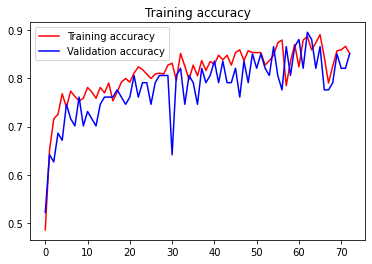

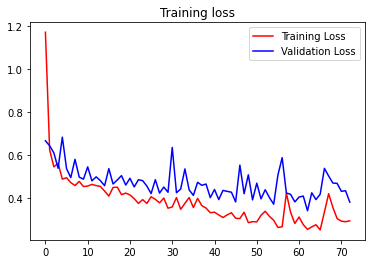

In [50]:
# Visualize Loss & Accuracy
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [51]:
model_4.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.3563 - accuracy: 0.8676


[0.35634922981262207, 0.8676470518112183]

#**Prediction**

In [52]:
predictions=model_3.predict(X_test, batch_size=None)

In [53]:
label=[]
for i in range(len(predictions)):
  if predictions[i][0]>0.5:
      label.append(1)
  else:
      label.append(0)

In [54]:
testing = pd.DataFrame()
testing['Stability'] = y_test
testing['Pred_Stability'] = label

In [55]:
testing.head(10)

,Stability,Pred_Stability
0,1,1
1,0,0
2,1,1
3,0,0
4,1,0
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [56]:
print(classification_report(testing['Stability'].values, testing['Pred_Stability'].values, zero_division=1))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87        26
           1       1.00      0.81      0.89        42

    accuracy                           0.88        68
   macro avg       0.88      0.90      0.88        68
weighted avg       0.91      0.88      0.88        68



In [57]:
stability_list = list(df['Stability'].unique())

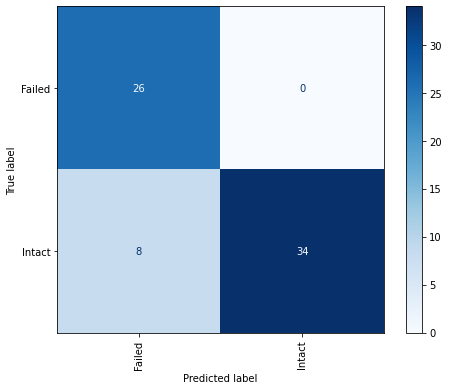

In [59]:
fig, ax = plt.subplots(figsize=(8,6))
matrix = ConfusionMatrixDisplay.from_predictions(testing['Stability'].values, testing['Pred_Stability'].values, display_labels=stability_list, cmap='Blues', ax=ax)
plt.xticks(rotation=90)
plt.show()